# AAE with no pretraining: Performance evaluation

Jacqueline R. M. A. Maasch | May 2022

## Preamble

In [72]:
# Importations.
import moses
import pandas as pd
import numpy as np
import time
import sys
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import wasserstein_distance
from moses.metrics import weight, logP, SA, QED
from moses.metrics.utils import get_mol, mapper
from moses import get_dataset
from collections import OrderedDict
from tdc.chem_utils import MolFilter
import warnings
from tdc import Oracle
from rdkit import Chem                                                                                                                                                                   
from rdkit import RDLogger 
from random import sample
import tdc
from tdc import Evaluator
from tdc.single_pred import HTS
from importlib.metadata import version

In [73]:
# View versioning.
print("\npython version:", sys.version)
print("\n--- LIBRARY VERSIONS ---")
print("tdc:         ", version("PyTDC"))
print("numpy:       ", version("numpy"))
print("pandas:      ", version("pandas"))
print("moses:       ", version("molsets"))
print("rdkit:       ", version("rdkit-pypi"))
print("scipy:       ", version("scipy"))
print("seaborn:     ", version("seaborn"))
print("matplotlib:  ", version("matplotlib"))


python version: 3.8.8 (default, Apr 13 2021, 12:59:45) 
[Clang 10.0.0 ]

--- LIBRARY VERSIONS ---
tdc:          0.3.6
numpy:        1.22.3
pandas:       1.2.4
moses:        0.3.1
rdkit:        2021.9.5.1
scipy:        1.7.2
seaborn:      0.11.1
matplotlib:   3.3.4


In [74]:
%%capture
# Installs.
#!python3.8 -m pip install fcd_torch
#!python3.8 -m pip install rxn4chemistry

## Define functions

In [75]:
def compute_tdc_metrics(generated, training):
    
    metrics_dict = dict()
    
    kl = Evaluator(name = "KL_Divergence")
    metrics_dict["KL divergence"] = kl(generated, training)

    uniqueness = Evaluator(name = "Uniqueness")
    metrics_dict["Uniqueness"] = uniqueness(generated)

    validity = Evaluator(name = "Validity")
    metrics_dict["Validity"] = validity(generated)

    novelty = Evaluator(name = "Novelty")
    metrics_dict["Novelty"] = novelty(generated, training)

    #fcd = Evaluator(name = "FCD_Distance")
    #metrics_dict["FCD distance"] = fcd(generated, training)

    diversity = Evaluator(name = "Diversity")
    metrics_dict["Diversity"] = diversity(generated)

    return metrics_dict


def remove_ungrammatical(generated):
    # Disable warnings.
    RDLogger.DisableLog("rdApp.*")  
    
    # Filter molecules.
    keep = []
    invalid_string = 0
    invalid_chemistry = 0
    for molecule in generated:
        m = Chem.MolFromSmiles(molecule, sanitize = False)
        if m is None:
            invalid_string += 1
        else:
            try:
                Chem.SanitizeMol(m)
                keep.append(molecule)
            except:
                invalid_chemistry += 1
                
    print("Total strings with invalid SMILES syntax:", invalid_string)
    print("Total strings with invalid chemistry:", invalid_chemistry)
    print("Total valid SMILES strings:", len(keep))
    print("Percent valid SMILES strings:", (len(keep) / len(generated)))
    
    return keep


def plot_distribution_basic(df, 
                            log_x = None, 
                            log_y = None, 
                            save_path = "./plt.pdf", 
                            save = False):
    
    sns.displot(data = df, 
                x = "Value", 
                hue = "Distribution", 
                col = "Metric",
                kind = "kde", 
                log_scale = (log_x, log_y),
                common_norm = True,
                fill = True,
                height = 5)
    if save:
        plt.savefig(save_path)
    else:
        plt.show()
    
    
def plot_distribution(df, 
                      log_x = None, 
                      log_y = None, 
                      save_path = "./plt.pdf", 
                      save = False):
    
    g = sns.FacetGrid(df.reset_index(), 
                      col = "Metric",
                      hue = "Distribution", 
                      sharex = False, 
                      sharey = False)
    g.map_dataframe(sns.kdeplot, 
                    "Value",
                    fill = True, 
                    log_scale = (log_x, log_y),
                    common_norm = True).add_legend()
    if save:
        plt.savefig(save_path)
    else:
        plt.show()

## Read data

### Generated molecules

In [76]:
# Read in generated molecules.
df_active = pd.read_csv("../aae/generated_molecules_100k/gen_active_finetune_50k.csv")
df_inactive = pd.read_csv("../aae/generated_molecules_100k/gen_inactive_finetune_50k.csv")

print(df_active.info())
display(df_active.head())

print(df_inactive.info())
display(df_inactive.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   SMILES  100000 non-null  object
dtypes: object(1)
memory usage: 781.4+ KB
None


,SMILES
0,c1cnccc1CNCc1ccc2c(c1)OCCN1c1cccnc1<pad><pad><...
1,CC(=O)Nc1c(C)sc1C<pad><pad><pad><pad><pad><pad...
2,O=C(c1cccnc1)N1C[C<unk>S<unk><unk><unk>CH1(COC...
3,CSC(=O)Oc1cc2cccc(NS(C)(=O)=O)c2c1OCl<pad><pad...
4,COc1ccc(C(=O)CCNCCCCl)cc1OClc1ccccc1<pad><pad>...


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   SMILES  100000 non-null  object
dtypes: object(1)
memory usage: 781.4+ KB
None


,SMILES
0,c1csc(N2CCN(C(C)C)CC2)n1<pad><pad><pad><pad><p...
1,CC(=O)Nc1c(C)sc2cccnc12<pad><pad><pad><pad><pa...
2,O=C([N<unk><unk>]<unk>N[C<unk>]<unk><unk>]=C<u...
3,C[O<unk>H](NC(=O)Oc1ccccc1<unk>Cl<unk>O)OCC<pa...
4,COc1ccc(C(=O)Nc2ccc3ncnn(-c43=O)[c<unk>]3C2=O)...


### Training data from TDC

In [77]:
df_active_train = pd.read_csv("../sars_data/actives_train.csv")
df_inactive_train = pd.read_csv("../sars_data/inactives_train.csv")

print(df_active_train.info())
display(df_active_train.head())
print(df_inactive_train.info())
display(df_inactive_train.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132 entries, 0 to 131
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   SMILES  132 non-null    object
dtypes: object(1)
memory usage: 1.2+ KB
None


,SMILES
0,NC(=O)c1ccc(NC(=O)[C@@H]2CCCO2)cc1
1,Cc1nccn1CC1CCc2c(c3ccccc3n2C)C1=O.Cl
2,COC(=O)Nc1sc(C)nc1-c1ccccc1
3,OC1CCN(Cc2ccsc2)CC1
4,CC(C(O)c1ccc(O)cc1)N1CCC(Cc2ccccc2)CC1.CC(C(O)...


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1758 entries, 0 to 1757
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   SMILES  1758 non-null   object
dtypes: object(1)
memory usage: 13.9+ KB
None


,SMILES
0,Nc1ccn([C@@H]2O[C@H](CO)[C@@H](O)[C@@H]2O)c(=O)n1
1,COc1cc(Br)c(C[N+]2(CCOCCC3CCC4CC3C4(C)C)CCOCC2...
2,O=C1CCc2ccc(OCCCCN3CCN(c4cccc(Cl)c4Cl)CC3)cc2N1
3,COCC1=C(C(=O)OC(C)OC(=O)OC(C)C)N2C(=O)[C@@H](N...
4,c1nc(N2CCC2)c2[nH]cnc2n1


### Validation data

In [78]:
df_active_val = pd.read_csv("../sars_data/actives_val.csv")
df_inactive_val = pd.read_csv("../sars_data/inactives_val.csv")

print(df_active_val.info())
display(df_active_val.head())
print(df_inactive_val.info())
display(df_inactive_val.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34 entries, 0 to 33
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   SMILES  34 non-null     object
dtypes: object(1)
memory usage: 400.0+ bytes
None


,SMILES
0,O=C(CCl)N1CCN(Cc2cccc3ccccc23)CC1
1,O=C(CCl)N1CCN(S(=O)(=O)c2cccs2)CC1
2,C[C@H]1CN(c2c(F)c(N)c3c(=O)c(C(=O)O)cn(C4CC4)c...
3,C/C=C/c1ccc(OC)cc1
4,Clc1cccc(CN2CCOCC2)c1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   SMILES  440 non-null    object
dtypes: object(1)
memory usage: 3.6+ KB
None


,SMILES
0,CCC1(C)CC(=O)NC1=O
1,CC(=O)N[C@@H](CCC(N)=O)C(=O)O
2,O=C1O[C@H]([C@@H](O)CO)C(O)=C1O
3,CC(C)n1cnc(S(N)(=O)=O)c1
4,Cc1ccc(=O)n(-c2ccccc2)c1


## Process data

In [79]:
# Remove padding.
remove_pad = lambda x: x.replace("<pad>", "")
df_active.SMILES = df_active.SMILES.map(remove_pad)
df_inactive.SMILES = df_inactive.SMILES.map(remove_pad)

In [80]:
# Listify.
actives_gen = list(df_active.SMILES)
inactives_gen = list(df_inactive.SMILES)

actives_train = list(df_active_train.SMILES)
inactives_train = list(df_inactive_train.SMILES)

actives_val = list(df_active_val.SMILES)
inactives_val = list(df_inactive_val.SMILES)

In [81]:
# Filter out molecules that do not pass RDKit checks.
# Some metrics will require this step.
print("--- de novo actives ---")
actives_gen_grammatical = remove_ungrammatical(actives_gen)
print("\n--- de novo inactives ---")
inactives_gen_grammatical = remove_ungrammatical(inactives_gen)
print("\n--- training actives ---")
actives_train_grammatical = remove_ungrammatical(actives_train)
print("\n--- training inactives ---")
inactives_train_grammatical = remove_ungrammatical(inactives_train)
print("\n--- validation actives ---")
actives_val_grammatical = remove_ungrammatical(actives_val)
print("\n--- validation inactives ---")
inactives_val_grammatical = remove_ungrammatical(inactives_val)

--- de novo actives ---
Total strings with invalid SMILES syntax: 60752
Total strings with invalid chemistry: 7255
Total valid SMILES strings: 31993
Percent valid SMILES strings: 0.31993

--- de novo inactives ---
Total strings with invalid SMILES syntax: 65249
Total strings with invalid chemistry: 5722
Total valid SMILES strings: 29029
Percent valid SMILES strings: 0.29029

--- training actives ---
Total strings with invalid SMILES syntax: 0
Total strings with invalid chemistry: 0
Total valid SMILES strings: 132
Percent valid SMILES strings: 1.0

--- training inactives ---
Total strings with invalid SMILES syntax: 0
Total strings with invalid chemistry: 0
Total valid SMILES strings: 1758
Percent valid SMILES strings: 1.0

--- validation actives ---
Total strings with invalid SMILES syntax: 0
Total strings with invalid chemistry: 0
Total valid SMILES strings: 34
Percent valid SMILES strings: 1.0

--- validation inactives ---
Total strings with invalid SMILES syntax: 0
Total strings wit

## Global-level metrics

### MOSES metrics

In [82]:
moses.get_all_metrics?

Signature:
moses.get_all_metrics(
    gen,
    k=None,
    n_jobs=1,
    device='cpu',
    batch_size=512,
    pool=None,
    test=None,
    test_scaffolds=None,
    ptest=None,
    ptest_scaffolds=None,
    train=None,
)
Docstring:
Computes all available metrics between test (scaffold test)
and generated sets of SMILES.
Parameters:
    gen: list of generated SMILES
    k: int or list with values for unique@k. Will calculate number of
        unique molecules in the first k molecules. Default [1000, 10000]
    n_jobs: number of workers for parallel processing
    device: 'cpu' or 'cuda:n', where n is GPU device number
    batch_size: batch size for FCD metric
    pool: optional multiprocessing pool to use for parallelization

    test (None or list): test SMILES. If None, will load
        a default test set
    test_scaffolds (None or list): scaffold test SMILES. If None, will
        load a default scaffold test set
    ptest (None or dict): precalculated statistics of the test set. 

In [83]:
# Compute MOSES metrics for de novo actives.
start_time = time.time()
metrics_active = moses.get_all_metrics(gen = actives_gen, train = actives_train, test = actives_val)
print("Complete in {} seconds.".format(time.time() - start_time))

display(metrics_active)

Complete in 1382.1852967739105 seconds.


{'valid': 0.31987,
 'unique@1000': 0.889,
 'unique@10000': 0.7537,
 'FCD/Test': 27.450040563778344,
 'SNN/Test': 0.26067202488801844,
 'Frag/Test': 0.7525109655738881,
 'Scaf/Test': 0.16187360452209054,
 'FCD/TestSF': 13.321869966029737,
 'SNN/TestSF': 0.4700151263386888,
 'Frag/TestSF': 0.8782204995746179,
 'Scaf/TestSF': 0.1782123069051209,
 'IntDiv': 0.8733363562146017,
 'IntDiv2': 0.8541130236348977,
 'Filters': 0.7708131428392785,
 'logP': 0.808918221768403,
 'SA': 0.5118855117990307,
 'QED': 0.07819819097371944,
 'weight': 103.19630473501189,
 'Novelty': 0.9972567071186126}

In [84]:
# Compute MOSES metrics for de novo inactives.
start_time = time.time()
metrics_inactive = moses.get_all_metrics(gen = inactives_gen, train = inactives_train, test = inactives_val)
print("Complete in {} seconds.".format(time.time() - start_time))

display(metrics_inactive)

Complete in 1227.492084980011 seconds.


{'valid': 0.29028,
 'unique@1000': 0.971,
 'unique@10000': 0.9046,
 'FCD/Test': 7.880299900695519,
 'SNN/Test': 0.3247830209672498,
 'Frag/Test': 0.9332156154456965,
 'Scaf/Test': 0.2151412951900018,
 'FCD/TestSF': 9.956743988653102,
 'SNN/TestSF': 0.4442641802014832,
 'Frag/TestSF': 0.9048575456060471,
 'Scaf/TestSF': 0.12293544479999619,
 'IntDiv': 0.8804771335869384,
 'IntDiv2': 0.8678371598038565,
 'Filters': 0.9089844288273391,
 'logP': 0.6122447390857733,
 'SA': 0.5004046383877903,
 'QED': 0.07364345268745749,
 'weight': 92.45310493410757,
 'Novelty': 0.9964783031088082}

### TDC metrics

In [88]:
# NOTE: must subsample generative inactives to < 10k to get TDC functions to work.
# This is due to a glitch in TDC.
actives_gen_grammatical_10k = sample(actives_gen_grammatical, 10000)
inactives_gen_grammatical_10k = sample(inactives_gen_grammatical, 10000)

In [86]:
%%capture
# Throws error.
'''
ompute all metrics for active de novos vs their training data.
compute_tdc_metrics(actives_gen_grammatical, actives_train_grammatical)
'''

In [92]:
# KL divergence of active generated data and active training data.
kl = Evaluator(name = "KL_Divergence")
kl(actives_gen_grammatical_10k, actives_train_grammatical)

RDKit ERROR: [21:01:45] Explicit valence for atom # 22 N, 4, is greater than permitted
[21:01:45] Explicit valence for atom # 22 N, 4, is greater than permitted
RDKit ERROR: [21:02:03] Explicit valence for atom # 4 N, 4, is greater than permitted
[21:02:03] Explicit valence for atom # 4 N, 4, is greater than permitted
RDKit ERROR: [21:02:06] Explicit valence for atom # 13 O, 3, is greater than permitted
[21:02:06] Explicit valence for atom # 13 O, 3, is greater than permitted
RDKit ERROR: [21:02:10] Explicit valence for atom # 22 N, 4, is greater than permitted
[21:02:10] Explicit valence for atom # 22 N, 4, is greater than permitted
RDKit ERROR: [21:02:11] Explicit valence for atom # 4 N, 4, is greater than permitted
[21:02:11] Explicit valence for atom # 4 N, 4, is greater than permitted
RDKit ERROR: [21:02:11] Explicit valence for atom # 13 O, 3, is greater than permitted
[21:02:11] Explicit valence for atom # 13 O, 3, is greater than permitted


0.6034449280889861

In [93]:
%%capture
# Throws error.
'''
# Compute all metrics for inactive de novos vs their training data.
compute_tdc_metrics(inactives_gen_grammatical_10k, inactives_train_grammatical)
'''

In [94]:
# KL divergence of inactive generated data and inactive training data.
kl(inactives_gen_grammatical_10k, inactives_train_grammatical)

0.681380640061506

In [95]:
# KL divergence of active training data and inactive training data.
kl(actives_train_grammatical, inactives_train_grammatical)

0.854377160131264

In [96]:
# KL divergence of active de novos and inactive training data.
kl(actives_gen_grammatical_10k, inactives_train_grammatical)

RDKit ERROR: [21:03:20] Explicit valence for atom # 22 N, 4, is greater than permitted
[21:03:20] Explicit valence for atom # 22 N, 4, is greater than permitted
RDKit ERROR: [21:03:34] Explicit valence for atom # 4 N, 4, is greater than permitted
[21:03:34] Explicit valence for atom # 4 N, 4, is greater than permitted
RDKit ERROR: [21:03:37] Explicit valence for atom # 13 O, 3, is greater than permitted
[21:03:37] Explicit valence for atom # 13 O, 3, is greater than permitted
RDKit ERROR: [21:03:46] Explicit valence for atom # 22 N, 4, is greater than permitted
[21:03:46] Explicit valence for atom # 22 N, 4, is greater than permitted
RDKit ERROR: [21:03:47] Explicit valence for atom # 4 N, 4, is greater than permitted
[21:03:47] Explicit valence for atom # 4 N, 4, is greater than permitted
RDKit ERROR: [21:03:47] Explicit valence for atom # 13 O, 3, is greater than permitted
[21:03:47] Explicit valence for atom # 13 O, 3, is greater than permitted


0.642507945507392

In [97]:
# KL divergence of inactive de novos and active training data.
kl(inactives_gen_grammatical_10k, actives_train_grammatical)

0.645278056135419

In [98]:
# KL divergence of active de novos and inactive de novos.
kl(actives_gen_grammatical_10k, inactives_gen_grammatical_10k)

RDKit ERROR: [21:04:47] Explicit valence for atom # 22 N, 4, is greater than permitted
[21:04:47] Explicit valence for atom # 22 N, 4, is greater than permitted
RDKit ERROR: [21:05:02] Explicit valence for atom # 4 N, 4, is greater than permitted
[21:05:02] Explicit valence for atom # 4 N, 4, is greater than permitted
RDKit ERROR: [21:05:05] Explicit valence for atom # 13 O, 3, is greater than permitted
[21:05:05] Explicit valence for atom # 13 O, 3, is greater than permitted
RDKit ERROR: [21:05:47] Explicit valence for atom # 22 N, 4, is greater than permitted
[21:05:47] Explicit valence for atom # 22 N, 4, is greater than permitted
RDKit ERROR: [21:05:48] Explicit valence for atom # 4 N, 4, is greater than permitted
[21:05:48] Explicit valence for atom # 4 N, 4, is greater than permitted
RDKit ERROR: [21:05:48] Explicit valence for atom # 13 O, 3, is greater than permitted
[21:05:48] Explicit valence for atom # 13 O, 3, is greater than permitted


0.9656131656390157

## Molecule-level metrics

### Synthetic accessibility

>Description: Synthetic Accessibility Score stands for how hard or how easy it is to synthesize a given molecule, based on a combination of the molecule’s fragments contributions. The oracle is caluated via RDKit, using a set of chemical rules defined by Ertl et al. (https://tdcommons.ai/functions/oracles/#ibm-rxn-synthetic-accessibility)[https://tdcommons.ai/functions/oracles/#ibm-rxn-synthetic-accessibility]

In [99]:
# Synthetic accessibility.
sa = Oracle(name = "SA")

'''
sa_actives_gen = sa(actives_gen_grammatical)
sa_inactives_gen = sa(inactives_gen_grammatical)
sa_actives_train = sa(actives_train_grammatical)
sa_inactives_train = sa(inactives_train_grammatical)
'''

invalid = 0
sa_actives_gen = []
for molecule in actives_gen_grammatical:
    try:
        sa_one = sa(molecule)
        sa_actives_gen.append(sa_one)
    except:
        invalid += 1
print("\nTotal invalid:", invalid)
print("Total valid:", len(sa_actives_gen))

invalid = 0
sa_inactives_gen = []
for molecule in inactives_gen_grammatical:
    try:
        sa_one = sa(molecule)
        sa_inactives_gen.append(sa_one)
    except:
        invalid += 1
print("\nTotal invalid:", invalid)
print("Total valid:", len(sa_inactives_gen))

invalid = 0
sa_actives_train = []
for molecule in actives_train_grammatical:
    try:
        sa_one = sa(molecule)
        sa_actives_train.append(sa_one)
    except:
        invalid += 1
print("\nTotal invalid:", invalid)
print("Total valid:", len(sa_actives_train))

invalid = 0
sa_inactives_train = []
for molecule in inactives_train_grammatical:
    try:
        sa_one = sa(molecule)
        sa_inactives_train.append(sa_one)
    except:
        invalid += 1
print("\nTotal invalid:", invalid)
print("Total valid:", len(sa_inactives_train))

print()
sa_dict = {"Generated actives": sa_actives_gen,
           "Generated inactives": sa_inactives_gen,
           "Training actives": sa_actives_train,
           "Training inactives": sa_inactives_train}

for key,value in sa_dict.items():
    print(key, ":")
    print(value[:20], "\n")


Total invalid: 0
Total valid: 31993

Total invalid: 0
Total valid: 29029

Total invalid: 0
Total valid: 132

Total invalid: 0
Total valid: 1758

Generated actives :
[1.8914270817698284, 2.774074562304854, 2.3279506013213993, 2.15315581111161, 1.7776486823101774, 1.7125877802636786, 1.9004771486527225, 2.005678033153675, 2.067939363605639, 2.31155821597069, 2.405988063858862, 4.754133177824384, 2.0148605913313897, 3.3192517200681904, 2.020876722571373, 3.1390826425345715, 1.964040453329856, 1.8431290622173222, 1.9401303832629893, 2.648101110310712] 

Generated inactives :
[2.172610585692139, 2.3611527750412513, 1.59409784648013, 2.15556969327597, 1.9901882574158094, 2.16452087074871, 2.7669875292647426, 2.552200073895465, 2.47291166611296, 1.5892015456870947, 2.4372618722644184, 1.907462734188531, 1.8176649869357853, 3.0716570706869746, 2.659704107803467, 1.424379277341643, 1.6327905856921365, 2.7197903053777512, 3.051969174207189, 2.438100560664381] 

Training actives :
[2.25064465275

### QED

> Description: QED stands for Quantitative Estimate of Drug-likeness. The oracle is caluated via RDKit, using a set of chemical rules about drug-likeliness defined by Bickerton et al. (https://tdcommons.ai/functions/oracles/#ibm-rxn-synthetic-accessibility)[https://tdcommons.ai/functions/oracles/]

In [100]:
# Address this error:
# RDKit ERROR: Explicit valence for atom # 14 C, 5, is greater than permitted.
inactives_gen_grammatical_keep = []
invalid_valence = 0
for molecule in inactives_gen_grammatical:
        m = Chem.MolFromSmiles(molecule, sanitize = True)
        try:
            m = Chem.RemoveHs(m)
            inactives_gen_grammatical_keep.append(molecule)
        except:
            invalid_valence += 1
print("Total de novo inactives with invalid valence:", invalid_valence)
print("Total de novo inactives with valid valence:", len(inactives_gen_grammatical_keep))

RDKit ERROR: [21:09:44] Explicit valence for atom # 1 O, 3, is greater than permitted
[21:09:44] Explicit valence for atom # 1 O, 3, is greater than permitted


Total de novo inactives with invalid valence: 1
Total de novo inactives with valid valence: 29028


In [101]:
# Address this error:
# RDKit ERROR: Explicit valence for atom # 14 C, 5, is greater than permitted.
actives_gen_grammatical_keep = []
invalid_valence = 0
for molecule in actives_gen_grammatical:
        m = Chem.MolFromSmiles(molecule, sanitize = True)
        try:
            m = Chem.RemoveHs(m)
            actives_gen_grammatical_keep.append(molecule)
        except:
            invalid_valence += 1
print("Total de novo actives with invalid valence:", invalid_valence)
print("Total de novo actives with valid valence:", len(actives_gen_grammatical_keep))

RDKit ERROR: [21:09:47] Explicit valence for atom # 1 O, 3, is greater than permitted
[21:09:47] Explicit valence for atom # 1 O, 3, is greater than permitted
RDKit ERROR: [21:09:47] Explicit valence for atom # 22 C, 5, is greater than permitted
[21:09:47] Explicit valence for atom # 22 C, 5, is greater than permitted
RDKit ERROR: [21:09:47] Explicit valence for atom # 4 N, 4, is greater than permitted
[21:09:47] Explicit valence for atom # 4 N, 4, is greater than permitted
RDKit ERROR: [21:09:48] Explicit valence for atom # 11 N, 4, is greater than permitted
[21:09:48] Explicit valence for atom # 11 N, 4, is greater than permitted
RDKit ERROR: [21:09:49] Explicit valence for atom # 13 N, 4, is greater than permitted
[21:09:49] Explicit valence for atom # 13 N, 4, is greater than permitted


Total de novo actives with invalid valence: 6
Total de novo actives with valid valence: 31987


RDKit ERROR: [21:09:50] Explicit valence for atom # 4 O, 3, is greater than permitted
[21:09:50] Explicit valence for atom # 4 O, 3, is greater than permitted


In [102]:
# Quantitative Estimate of Drug-likeness.
qed = Oracle(name = "QED")
qed_actives_gen = qed(actives_gen_grammatical_keep) # Use only instances with proper valence.
qed_inactives_gen = qed(inactives_gen_grammatical_keep) # Use only instances with proper valence.
qed_actives_train = qed(actives_train_grammatical)
qed_inactives_train = qed(inactives_train_grammatical)

qed_dict = {"Generated actives": qed_actives_gen,
            "Generated inactives": qed_inactives_gen,
            "Training actives": qed_actives_train,
            "Training inactives": qed_inactives_train}

for key,value in qed_dict.items():
    print(key, ":")
    print(value[:20], "\n")

Generated actives :
[0.5963106704352279, 0.8053838185438956, 0.6873315858365848, 0.7368102338973656, 0.66839051745473, 0.7512553938498276, 0.7735661762236712, 0.7774913062940729, 0.6320176695605052, 0.4259698899972951, 0.840466866560758, 0.794116510440555, 0.7524501630493927, 0.6234381652073878, 0.6703774535257511, 0.8997188382996835, 0.7915462676183185, 0.8760355461269528, 0.3237090602352409, 0.8378944005311567] 

Generated inactives :
[0.741629203658873, 0.7787364041667866, 0.7988810473911021, 0.6356552607915211, 0.8488962727774265, 0.7501610950654981, 0.7897089179575055, 0.6513625026963701, 0.8990773808234841, 0.7098263457706235, 0.767307490704023, 0.7395510143871346, 0.7501705618158822, 0.32161643271763335, 0.6548455518910674, 0.8514528641506841, 0.7586672745468016, 0.8246570964899207, 0.838209136756911, 0.8091776404783222] 

Training actives :
[0.814913995911437, 0.7209997551181787, 0.8867424621741485, 0.7798427952514674, 0.08557107474966161, 0.7958887434961184, 0.6113669325066001

### Octanol-water Partition Coefficient (LogP)

>Description: The penalized logP score measures the solubility and synthetic accessibility of a compound. The oracle is caluated via RDKit. (https://tdcommons.ai/functions/oracles/#ibm-rxn-synthetic-accessibility)[https://tdcommons.ai/functions/oracles/]

In [103]:
# LogP.
logp = Oracle(name = "LogP")

'''
logp_actives_gen = logp(actives_gen_grammatical)
logp_inactives_gen = logp(inactives_gen_grammatical)
logp_actives_train = logp(actives_train_grammatical)
logp_inactives_train = logp(inactives_train_grammatical)
'''

invalid = 0
logp_actives_gen = []
for molecule in actives_gen_grammatical:
    try:
        logp_one = logp(molecule)
        logp_actives_gen.append(logp_one)
    except:
        invalid += 1
print("\nTotal invalid:", invalid)
print("Total valid:", len(logp_actives_gen))

invalid = 0
logp_inactives_gen = []
for molecule in inactives_gen_grammatical:
    try:
        logp_one = logp(molecule)
        logp_inactives_gen.append(logp_one)
    except:
        invalid += 1
print("\nTotal invalid:", invalid)
print("Total valid:", len(logp_inactives_gen))

invalid = 0
logp_actives_train = []
for molecule in actives_train_grammatical:
    try:
        logp_one = logp(molecule)
        logp_actives_train.append(logp_one)
    except:
        invalid += 1
print("\nTotal invalid:", invalid)
print("Total valid:", len(logp_actives_train))

invalid = 0
logp_inactives_train = []
for molecule in inactives_train_grammatical:
    try:
        logp_one = logp(molecule)
        logp_inactives_train.append(logp_one)
    except:
        invalid += 1
print("\nTotal invalid:", invalid)
print("Total valid:", len(logp_inactives_train))

print()
logp_dict = {"Generated actives": logp_actives_gen,
             "Generated inactives": logp_inactives_gen,
             "Training actives": logp_actives_train,
             "Training inactives": logp_inactives_train}

for key,value in logp_dict.items():
    print(key, ":")
    print(value[:20], "\n")


Total invalid: 0
Total valid: 31993

Total invalid: 0
Total valid: 29029

Total invalid: 0
Total valid: 132

Total invalid: 0
Total valid: 1758

Generated actives :
[1.3316416139243048, -0.44827782085774337, -3.3474665919771462, 0.12493871136895596, 0.3134410873897562, 2.772199337455984, -0.44263857999655687, 0.33840514180296055, 0.7366278552209504, 3.1846515369566375, 0.752638874102169, -19.296114041146307, 0.8996579737921658, 0.11007414864663034, 2.8165377430870615, -0.9351180150123579, 0.6483420331656747, 1.4606161655810947, 0.5693114493949, 0.16393752889318464] 

Generated inactives :
[0.6792220918628576, 1.0732585825504894, 1.724526830572149, 0.675195114478471, 0.09693594772492098, 0.20096264176058698, 0.8907465879651693, 0.603438335239685, 0.3189418018380714, 1.9489708724949777, 0.29282933370441344, -0.4284303661288389, 1.8522421050729045, -2.437284410859551, 1.0992165587716143, 2.815404260374387, 1.6945597203802074, 0.7551545942176672, 0.8669743574284671, 0.641116501255538] 

T

### Dictionary to dataframe

In [104]:
# SA.
df_sa = pd.DataFrame()
for key,value in sa_dict.items():
    df_sa = pd.concat([df_sa, pd.DataFrame({"Distribution": [key] * len(value), "Value": value})])
df_sa["Metric"] = "SA"
display(df_sa)

,Distribution,Value,Metric
0,Generated actives,1.891427,SA
1,Generated actives,2.774075,SA
2,Generated actives,2.327951,SA
3,Generated actives,2.153156,SA
4,Generated actives,1.777649,SA
...,...,...,...
1753,Training inactives,1.919343,SA
1754,Training inactives,2.494935,SA
1755,Training inactives,4.908138,SA
1756,Training inactives,2.417861,SA


In [105]:
# QED.
df_qed = pd.DataFrame()
for key,value in qed_dict.items():
    df_qed = pd.concat([df_qed, pd.DataFrame({"Distribution": [key] * len(value), "Value": value})])
df_qed["Metric"] = "QED"
display(df_qed)

,Distribution,Value,Metric
0,Generated actives,0.596311,QED
1,Generated actives,0.805384,QED
2,Generated actives,0.687332,QED
3,Generated actives,0.736810,QED
4,Generated actives,0.668391,QED
...,...,...,...
1753,Training inactives,0.736693,QED
1754,Training inactives,0.877740,QED
1755,Training inactives,0.675608,QED
1756,Training inactives,0.834182,QED


In [106]:
# LogP.
df_logp = pd.DataFrame()
for key,value in logp_dict.items():
    df_logp = pd.concat([df_logp, pd.DataFrame({"Distribution": [key] * len(value), "Value": value})])
df_logp["Metric"] = "LogP"
display(df_logp)

,Distribution,Value,Metric
0,Generated actives,1.331642,LogP
1,Generated actives,-0.448278,LogP
2,Generated actives,-3.347467,LogP
3,Generated actives,0.124939,LogP
4,Generated actives,0.313441,LogP
...,...,...,...
1753,Training inactives,1.354121,LogP
1754,Training inactives,1.682860,LogP
1755,Training inactives,-1.982381,LogP
1756,Training inactives,0.699492,LogP


In [107]:
# Aggregate all results.
df_metrics = pd.concat([df_sa, df_qed, df_logp]).reset_index(drop = True)
print(df_metrics.info())
display(df_metrics)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188729 entries, 0 to 188728
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Distribution  188729 non-null  object 
 1   Value         188729 non-null  float64
 2   Metric        188729 non-null  object 
dtypes: float64(1), object(2)
memory usage: 4.3+ MB
None


,Distribution,Value,Metric
0,Generated actives,1.891427,SA
1,Generated actives,2.774075,SA
2,Generated actives,2.327951,SA
3,Generated actives,2.153156,SA
4,Generated actives,1.777649,SA
...,...,...,...
188724,Training inactives,1.354121,LogP
188725,Training inactives,1.682860,LogP
188726,Training inactives,-1.982381,LogP
188727,Training inactives,0.699492,LogP


## Plot distributions

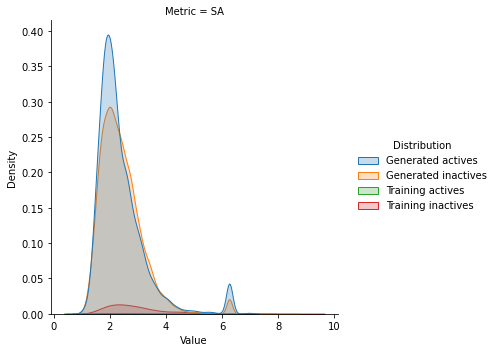

In [108]:
plot_distribution_basic(df_sa)

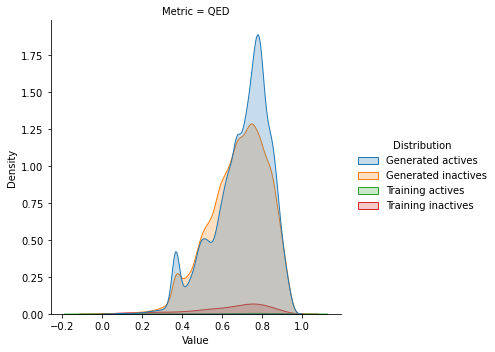

In [109]:
plot_distribution_basic(df_qed)

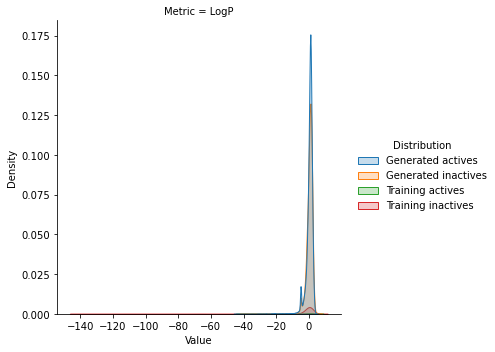

In [110]:
plot_distribution_basic(df_logp)

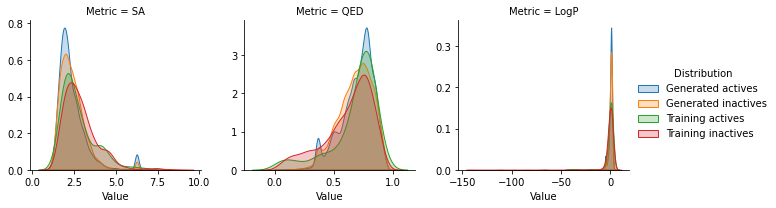

In [111]:
plot_distribution(df_metrics, save_path = "./aae_finetune_50k_metrics.pdf", save = True)

## End of document